# Lab 4 - Comparing Classification Models



---















In this session, we demonstrate how to solve a text classification task using simple 
feedforward neural network classifier. We will use IMDB Large Movie Review Dataset to train a binary classification model, able to predict whether a review is positive or negative. First, our network takes one-hot word vectors as input, averages them to make one vector and trains a 
fully-connected layer to predict the output. In the second part, we replace the one-hot vectors with the word embeddings and add a layer to see how much that improves the performance.

We are going to use Keras Sequential API in this session. The Sequential API allows you to make models layer-by-layer. But it is not straightforward to define models where layers connect to more than just the previous and next layers. 

In [ ]:
import keras
import numpy as np
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding, GlobalMaxPooling1D
from keras import backend as K
from keras.models import Sequential
import matplotlib.pyplot as plt


### Downloading data

The dataset we will be using is the IMDB Large Movie Review Dataset, which consists of 50000 labeled movie reviews. These are split into 25,000 reviews for training and 25,000 reviews for testing. The  dataset contains an even number of positive and negative reviews, so randomly guessing yields 50% accuracy. The data is preprocessed. For text classification, it is ususal to limit the size of the vocabulary to stop the dataset from becoming too sparse, creating possible overfitting. We keep the top 10,000 most frequently occurring words in the training data.


In [ ]:
imdb = keras.datasets.imdb
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

We now can start playing around with the data, let’s first see the length:

In [ ]:
print("Training entries: {}, labels: {}".format(len(X_train), len(y_train)))

Training entries: 25000, labels: 25000


The  reviews have been converted to integers and each integer represents a  word in a dictionary. 

In [ ]:
 X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

We can convert integers back to words by querying a dictionary object that contains the integer to string mapping:

In [ ]:
word_index = imdb.get_word_index()

Index 1 represents the beginning of the sentence and the index 2 is assigned to all unknown tokens. Index 0 will be used for padding.

In [ ]:
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  
word_index["<UNUSED>"] = 3

To reverse key and values in a dictionary:

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

To view a word:

In [ ]:
reverse_word_index[25]

'you'

And to recreate the whole sentence from our training data we define decode_review:


In [ ]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [ ]:
decode_review(X_train[10])

"<START> french horror cinema has seen something of a revival over the last couple of years with great films such as inside and <UNK> romance <UNK> on to the scene <UNK> <UNK> the revival just slightly but stands head and shoulders over most modern horror titles and is surely one of the best french horror films ever made <UNK> was obviously shot on a low budget but this is made up for in far more ways than one by the originality of the film and this in turn is <UNK> by the excellent writing and acting that ensure the film is a winner the plot focuses on two main ideas prison and black magic the central character is a man named <UNK> sent to prison for fraud he is put in a cell with three others the quietly insane <UNK> body building <UNK> marcus and his retarded boyfriend daisy after a short while in the cell together they stumble upon a hiding place in the wall that contains an old <UNK> after <UNK> part of it they soon realise its magical powers and realise they may be able to use it

### Creating One-hot word vectors

It is  common to use one-hot representation as input in Natural Language Processing tasks. In Keras, the Embedding layer takes an index as an input and convert it to one-hot vector with the length of the vocabulary size. Then multiplies these vectors by a normal weight matrix. But there is no way to only get a one-hot vector as the output of a layer in Keras. To solve this we use Lambda() layer and a function that creates the one-hot layer. 

In [ ]:
def OneHot(input_dim=None, input_length=None):
    
    if input_dim is None or input_length is None:
        raise TypeError("input_dim or input_length is not set")

    
    def _one_hot(x, num_classes):
        return K.one_hot(K.cast(x, 'uint8'),
                          num_classes=num_classes)

    return Lambda(_one_hot,
                  arguments={'num_classes': input_dim},
                  input_shape=(input_length,))

input_dim refers to the length of the one-hot vector and input_length refers to the length of the input sequence. Since the input to K.one_hot should be an integer tensor, we cast x to one (Keras passes around float tensors by default).



 Each text sequence has in most cases different length of words. Here, we fill sequences with a pad token (0) to fit the size. This special tokens is then masked not to be accounted in averaging, loss calculation etc. We set the maximum length to 256.

### Preparing input data

In [ ]:
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 256

X_train_enc = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

X_test_enc = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

And to view a padded review:

In [ ]:
print(X_train_enc[1])
print('\nLength: ',len(X_train_enc))

[   1  194 1153  194 8255   78  228    5    6 1463 4369 5012  134   26
    4  715    8  118 1634   14  394   20   13  119  954  189  102    5
  207  110 3103   21   14   69  188    8   30   23    7    4  249  126
   93    4  114    9 2300 1523    5  647    4  116    9   35 8163    4
  229    9  340 1322    4  118    9    4  130 4901   19    4 1002    5
   89   29  952   46   37    4  455    9   45   43   38 1543 1905  398
    4 1649   26 6853    5  163   11 3215    2    4 1153    9  194  775
    7 8255    2  349 2637  148  605    2 8003   15  123  125   68    2
 6853   15  349  165 4362   98    5    4  228    9   43    2 1157   15
  299  120    5  120  174   11  220  175  136   50    9 4373  228 8255
    5    2  656  245 2350    5    4 9837  131  152  491   18    2   32
 7464 1212   14    9    6  371   78   22  625   64 1382    9    8  168
  145   23    4 1690   15   16    4 1355    5   28    6   52  154  462
   33   89   78  285   16  145   95    0    0    0    0    0    0    0
    0 

Now we want to build the neural network model. We  are going to have a hidden layer with 16 hidden units. 

First, we want to transform each index to an embedded vector and then average all vectors to a single one. It has been showed that unweighted average of word vectors outperforms many complicated networks that model semantic and syntactic compositionality. As an example you can take a look at this: (http://anthology.aclweb.org/P/P15/P15-1162.pdf)

To average we need to ignore padded zeros:

In [ ]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)


# Model 1: Neural averaging network using one-hot vectors

The first layer is an one-hot layer. The second layer is to compute average on all word vectors in a sentence without considering padding. The  output vector is piped through a fully-connected layer. The last layer is connected with a single output node with the sigmoid activation function. The final value is a float between 0 and 1. 
The vocabulary count of the movie reviews (10000) is used as the input shape. At the end we visualize the model summary.

In [ ]:

EMBED_SIZE = 100
from keras.layers import Input, Embedding, Dense, LSTM, Lambda, GlobalAveragePooling1D
from keras import backend as K
from keras.models import Model
input_layer = Input(shape=(256,))
lambda_layer = OneHot(VOCAB_SIZE, EMBED_SIZE)(input_layer)
pooling_layer = GlobalAveragePooling1DMasked()(lambda_layer)
hidden_dense_layer = Dense(16)(pooling_layer)
output_dense_layer = Dense(1, activation = 'sigmoid')(hidden_dense_layer)

**<i> <font color ='darkblue'>In this model, we first add an input layer which accepts input with shape equal to 256 corresponding to the maximum length of padded sequences. Next layer is the lambda layer which is used for the one hot representation which uses 10000 as vocabulary size and embedding size as 100 following which, we add the pooling layer and then a dense layer. Finally, we add the output dense layer with sigmoid activation function since we are expecting a binary output.</font></i>**

### Training the model

To compile the model we need a loss function and an optimizer. We use binary_crossentropy loss function which is just a special case of categorical cross entropy. We also use Adam optimizer that can be used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data. You can read more about it here:
(https://arxiv.org/abs/1412.6980v8
)


In [ ]:

model1 = Model(inputs= input_layer, outputs=output_dense_layer)
model1.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 256)]             0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 256, 10000)        0         
_________________________________________________________________
global_average_pooling1d_mas (None, 10000)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                160016    
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


**<i> <font color ='darkblue'>We finally create the model using the input and output layers which we defined previously and compile the model using adam optimizer and binary cross entropy as the loss function.</font></i>**

When training, we want to check the accuracy of the model on data it hasn't seen before. So we create a validation set:

In [ ]:
X_val = np.array(X_train_enc[:10000])
partial_X_train = np.array(X_train_enc[10000:])

y_val = np.array(y_train[:10000])
partial_y_train = np.array(y_train[10000:])

Then we start to train the model for 40 epochs in mini-batches of 512 samples and monitor the model's loss and accuracy on the validation set.

In [ ]:
# Model training
history = model1.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 47s 2s/step - loss: 0.6927 - accuracy: 0.5143 - val_loss: 0.6912 - val_accuracy: 0.5183
Epoch 2/40
30/30 [==============================] - 44s 1s/step - loss: 0.6902 - accuracy: 0.5276 - val_loss: 0.6884 - val_accuracy: 0.6663
Epoch 3/40
30/30 [==============================] - 44s 1s/step - loss: 0.6872 - accuracy: 0.6685 - val_loss: 0.6852 - val_accuracy: 0.6569
Epoch 4/40
30/30 [==============================] - 44s 1s/step - loss: 0.6837 - accuracy: 0.6485 - val_loss: 0.6811 - val_accuracy: 0.6652
Epoch 5/40
30/30 [==============================] - 44s 1s/step - loss: 0.6795 - accuracy: 0.6770 - val_loss: 0.6769 - val_accuracy: 0.6665
Epoch 6/40
30/30 [==============================] - 44s 1s/step - loss: 0.6745 - accuracy: 0.6692 - val_loss: 0.6716 - val_accuracy: 0.6709
Epoch 7/40
30/30 [==============================] - 44s 1s/step - loss: 0.6686 - accuracy: 0.6788 - val_loss: 0.6665 - val_accuracy: 0.6773
Epoch 8/40
30/30 [==

### Evaluating the model

To evaulate the model on test data:

In [ ]:
#Model evaluation
results = model1.evaluate(X_test_enc, y_test)

782/782 [==============================] - 56s 71ms/step - loss: 0.5340 - accuracy: 0.7422


In [ ]:
print(results)
# loss, accuracay 

[0.5339610576629639, 0.7422400116920471]


Our first model accuracy using one-hot vectors is ~68%







### Plotting the accuracy graph

To plot a graph of accuracy and loss over time we can use Matplotlib:

In [ ]:
pip install plot_keras_history

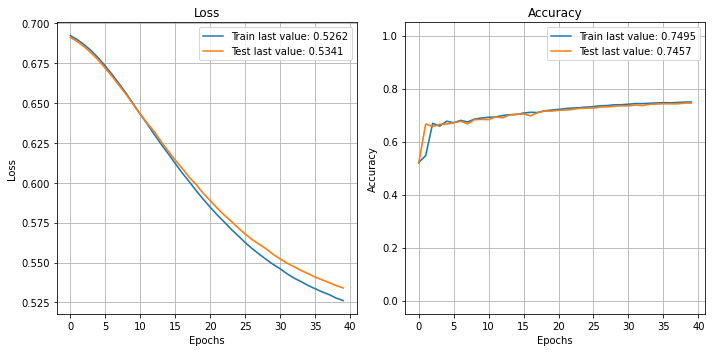

In [ ]:

from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()

**<i> <font color ='darkblue'>The model seems performs good enough by achieving an accuracy of 74% on test set which is equivalent to the performance on training and validation data as seen from the accuracy plot. Similarity is also observed in the values for loss for all three datasets.</font></i>**

# Model 2: Neural averaging network using embedding layer

Now instead of one-hot vectors, we want to use embedding. We change our first layer in model1 to an Embedding layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).

In [ ]:

from keras.layers import Input, Embedding, Dense, LSTM, Lambda
from keras.models import Model
input_layer = Input(shape=(256,))
embedding_layer = Embedding(input_dim = VOCAB_SIZE, output_dim = EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH)(input_layer)
pooling_layer = GlobalAveragePooling1DMasked()(embedding_layer)
hidden_dense_layer = Dense(16)(pooling_layer)
output_dense_layer = Dense(1, activation='sigmoid')(hidden_dense_layer)
model2 = Model(inputs= input_layer, outputs=output_dense_layer)
model2.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model2.summary()


Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 256)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 256, 100)          1000000   
_________________________________________________________________
global_average_pooling1d_mas (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 16)                1616      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 17        
Total params: 1,001,633
Trainable params: 1,001,633
Non-trainable params: 0
_________________________________________________________________


**<i> <font color ='darkblue'>We reuse the previous model but instead of using one-hot vector representation for words, we use the embeddings created by the Embedding Layer provided by Keras. We pass the same parameters and corresponding values to the Embedding Layer as it was done in the Lambda layer in model1.</font></i>**

In [ ]:
# Model training
history = model2.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 2s 59ms/step - loss: 0.6903 - accuracy: 0.6019 - val_loss: 0.6761 - val_accuracy: 0.7341
Epoch 2/40
30/30 [==============================] - 2s 52ms/step - loss: 0.6642 - accuracy: 0.7394 - val_loss: 0.6261 - val_accuracy: 0.7477
Epoch 3/40
30/30 [==============================] - 2s 51ms/step - loss: 0.6000 - accuracy: 0.7702 - val_loss: 0.5467 - val_accuracy: 0.7839
Epoch 4/40
30/30 [==============================] - 2s 51ms/step - loss: 0.5080 - accuracy: 0.8119 - val_loss: 0.4649 - val_accuracy: 0.8221
Epoch 5/40
30/30 [==============================] - 2s 51ms/step - loss: 0.4205 - accuracy: 0.8489 - val_loss: 0.3992 - val_accuracy: 0.8479
Epoch 6/40
30/30 [==============================] - 2s 51ms/step - loss: 0.3525 - accuracy: 0.8747 - val_loss: 0.3581 - val_accuracy: 0.8619
Epoch 7/40
30/30 [==============================] - 2s 51ms/step - loss: 0.3071 - accuracy: 0.8920 - val_loss: 0.3330 - val_accuracy: 0.8701
Epoch 8/40
30

In [ ]:
# Model evaluation
results = model2.evaluate(X_test_enc, y_test)

782/782 [==============================] - 2s 2ms/step - loss: 0.5795 - accuracy: 0.8537


In [ ]:
print (results)

[0.5795008540153503, 0.8537200093269348]


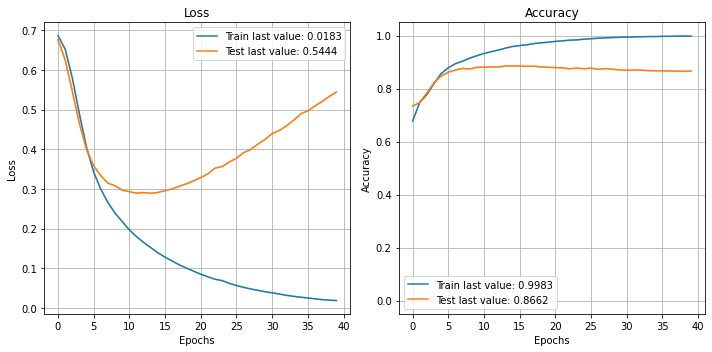

In [ ]:


from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()

The accuracy of model2 is 87%. Using Embedding layer instead of one-hot layer improved the performance.

# Model 3: Using pre-trained word embeddings

### Preparing pre-trained word embeddings (GLOVE)

The Embedding layer can be used to load a pre-trained word embedding model. We are going to use GloVe embeddings, which you can read about it here (https://nlp.stanford.edu/projects/glove/). GloVe stands for "Global Vectors for Word Representation". It's a somewhat popular embedding technique based on factorizing a matrix of word co-occurence statistics. You can download GloVe and we can seed the Keras Embedding layer with weights from the pre-trained embedding for the words in your dataset.
First, we need to read GloVe and map words to GloVe:


In [ ]:
def readGloveFile(gloveFile):
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  
        wordToIndex = {}  
        indexToWord = {}  

        for line in f:
            record = line.strip().split()
            token = record[0] 
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) 
            
        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  
            wordToIndex[tok] = kerasIdx 
            indexToWord[kerasIdx] = tok 

    return wordToIndex, indexToWord, wordToGlove

Now, we create our pre-trained Embedding layer:

In [ ]:
from keras.initializers import Constant

def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable, name='GloVe_Embeddings')
    return embeddingLayer

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip '/content/glove.6B.zip'

--2021-03-03 21:31:12--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-03 21:31:13--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-03-03 21:31:13--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

We freeze the weights. To create the model: 

In [ ]:
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.50d.txt')
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.100d.txt')
wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.300d.txt')

# vocabLen = len(wordToIndex) + 1 

EMBED_SIZE = next(iter(wordToGlove.values())).shape[0]
print('Size of Embedding: ',EMBED_SIZE)

embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)

Size of Embedding:  300


## Model 3-1: Neural bag of words using pre-trained word embeddings

Now we change our model to use GloVe:

In [ ]:
# Inspect model performance with 1 hidden layer, pre-trained embeddings

from keras.layers import Input, Embedding, Dense, LSTM, Lambda
from keras.models import Model
input_layer = Input(shape=(256,))
embedding_layer = embeddingLayer(input_layer)
pooling_layer = GlobalAveragePooling1DMasked()(embedding_layer)
hidden_dense_layer = Dense(16)(pooling_layer)
output_dense_layer = Dense(1, activation='sigmoid')(hidden_dense_layer)
model3 = Model(inputs= input_layer, outputs=output_dense_layer)
model3.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 256)]             0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, 256, 300)          120000300 
_________________________________________________________________
global_average_pooling1d_mas (None, 300)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 16)                4816      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 17        
Total params: 120,005,133
Trainable params: 4,833
Non-trainable params: 120,000,300
_________________________________________________________________


**<i> <font color ='darkblue'>In this section, we try another kind of embedding namely GloVe word embeddings that are pre-trained replacing the embeddings from the Embedding Layer provided by Keras. Since we want to make use of the pretrained word embeddings, we set isTrainable to false in the new embedding layer. </font></i>**

In [ ]:
# Model training
history = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)


Epoch 1/40
30/30 [==============================] - 3s 70ms/step - loss: 0.6940 - accuracy: 0.5038 - val_loss: 0.6845 - val_accuracy: 0.5545
Epoch 2/40
30/30 [==============================] - 2s 60ms/step - loss: 0.6825 - accuracy: 0.5687 - val_loss: 0.6774 - val_accuracy: 0.5801
Epoch 3/40
30/30 [==============================] - 2s 60ms/step - loss: 0.6726 - accuracy: 0.5926 - val_loss: 0.6684 - val_accuracy: 0.6011
Epoch 4/40
30/30 [==============================] - 2s 60ms/step - loss: 0.6650 - accuracy: 0.6068 - val_loss: 0.6608 - val_accuracy: 0.6168
Epoch 5/40
30/30 [==============================] - 2s 60ms/step - loss: 0.6567 - accuracy: 0.6255 - val_loss: 0.6548 - val_accuracy: 0.6261
Epoch 6/40
30/30 [==============================] - 2s 59ms/step - loss: 0.6493 - accuracy: 0.6336 - val_loss: 0.6450 - val_accuracy: 0.6453
Epoch 7/40
30/30 [==============================] - 2s 59ms/step - loss: 0.6442 - accuracy: 0.6456 - val_loss: 0.6380 - val_accuracy: 0.6535
Epoch 8/40
30

In [ ]:
# Model evaluation
results = model3.evaluate(X_test_enc, y_test)

782/782 [==============================] - 3s 3ms/step - loss: 0.5557 - accuracy: 0.7167


In [ ]:
print (results)

[0.5556595921516418, 0.7167199850082397]


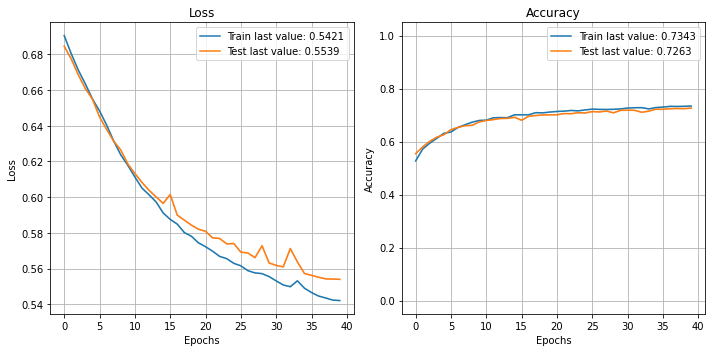

In [ ]:

from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()

To compare freezing and fine-tuning the pre-train embedding weights, we fine-tune the weights here:

In [ ]:

# Inspect model performance with 1 hidden layer, pre-trained embeddings
from keras.layers import Input, Embedding, Dense, LSTM, Lambda
from keras.models import Model
embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=True)
input_layer = Input(shape=(256,))
embedding_layer = embeddingLayer(input_layer)
pooling_layer = GlobalAveragePooling1DMasked()(embedding_layer)
hidden_dense_layer = Dense(16)(pooling_layer)
output_dense_layer = Dense(1, activation='sigmoid')(hidden_dense_layer)
model3 = Model(inputs= input_layer, outputs=output_dense_layer)
model3.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 256)]             0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, 256, 300)          120000300 
_________________________________________________________________
global_average_pooling1d_mas (None, 300)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 16)                4816      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 17        
Total params: 120,005,133
Trainable params: 120,005,133
Non-trainable params: 0
_________________________________________________________________


**<i> <font color ='darkblue'>In this previous section, we had set isTrainable to false in the embedding layer but we make it true for this model to compare the pretrained embeddings with the fine-tuned ones. </font></i>**

In [ ]:
# Model training
history = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 26s 835ms/step - loss: 0.6988 - accuracy: 0.5119 - val_loss: 0.6744 - val_accuracy: 0.5982
Epoch 2/40
30/30 [==============================] - 24s 796ms/step - loss: 0.6643 - accuracy: 0.6470 - val_loss: 0.6383 - val_accuracy: 0.6838
Epoch 3/40
30/30 [==============================] - 24s 796ms/step - loss: 0.6181 - accuracy: 0.7122 - val_loss: 0.5788 - val_accuracy: 0.7462
Epoch 4/40
30/30 [==============================] - 24s 793ms/step - loss: 0.5463 - accuracy: 0.7716 - val_loss: 0.4955 - val_accuracy: 0.8061
Epoch 5/40
30/30 [==============================] - 24s 794ms/step - loss: 0.4571 - accuracy: 0.8313 - val_loss: 0.4185 - val_accuracy: 0.8378
Epoch 6/40
30/30 [==============================] - 24s 795ms/step - loss: 0.3712 - accuracy: 0.8677 - val_loss: 0.3691 - val_accuracy: 0.8531
Epoch 7/40
30/30 [==============================] - 24s 795ms/step - loss: 0.3180 - accuracy: 0.8839 - val_loss: 0.3368 - val_accuracy: 0.8653

In [ ]:
# Model evaluation
results = model3.evaluate(X_test_enc, y_test)

782/782 [==============================] - 3s 4ms/step - loss: 0.6147 - accuracy: 0.8516


In [ ]:
print (results)

[0.6146966218948364, 0.8515599966049194]


**<i> <font color ='darkblue'>We can see that the accuracy on test set has significantly improved by almost 14% by using customized word embeddings when compared with the model with pretrained embeddings. </font></i>**

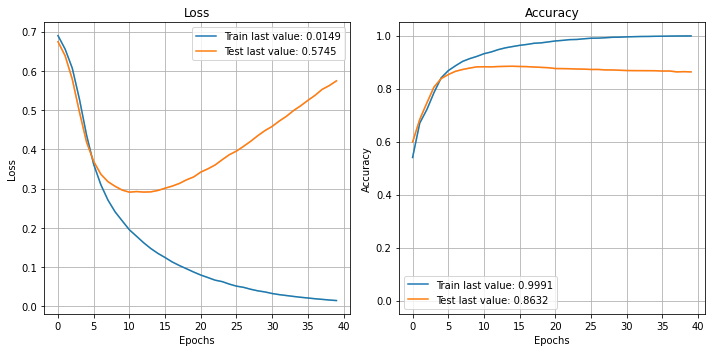

In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()

Experiments here show that fine-tuning the pre-trained embeddings would obtain better accuracy.

Note that although fine-tuning the pre-trained embeddings is better here, we do not fine-tune it in other models. You could conduct extra experiments to compare the results.

##  Model 3-2: LSTM with pre-trained word embeddings

In previous labs, we have conducted an experiment based on LSTM. Now, we replace its embeddings with the GloVe pre-trained embeddings.

In [ ]:
from keras.layers import Input, Embedding, Dense, LSTM, Lambda
from keras.models import Model
embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)
input_layer = Input(shape=(256,))
embedding_layer = embeddingLayer(input_layer)
lstm_layer = LSTM(100, return_sequences=False)(embedding_layer)
output_dense_layer = Dense(1, activation='sigmoid')(lstm_layer)
model3 = Model(inputs= input_layer, outputs=output_dense_layer)
model3.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 256)]             0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, 256, 300)          120000300 
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 101       
Total params: 120,160,801
Trainable params: 160,501
Non-trainable params: 120,000,300
_________________________________________________________________


**<i> <font color ='darkblue'> Borrowing the model from Lab 2, we have replaced the embeddings in that model with GloVe word embeddings. </font></i>**

In [ ]:
# Model training
history = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 77s 3s/step - loss: 0.6944 - accuracy: 0.5143 - val_loss: 0.6852 - val_accuracy: 0.5264
Epoch 2/40
30/30 [==============================] - 66s 2s/step - loss: 0.6795 - accuracy: 0.5424 - val_loss: 0.6730 - val_accuracy: 0.5666
Epoch 3/40
30/30 [==============================] - 71s 2s/step - loss: 0.6706 - accuracy: 0.5649 - val_loss: 0.6803 - val_accuracy: 0.5332
Epoch 4/40
30/30 [==============================] - 64s 2s/step - loss: 0.6670 - accuracy: 0.5632 - val_loss: 0.6597 - val_accuracy: 0.6339
Epoch 5/40
30/30 [==============================] - 68s 2s/step - loss: 0.6453 - accuracy: 0.6196 - val_loss: 0.6428 - val_accuracy: 0.6423
Epoch 6/40
30/30 [==============================] - 72s 2s/step - loss: 0.6345 - accuracy: 0.6521 - val_loss: 0.6768 - val_accuracy: 0.5319
Epoch 7/40
30/30 [==============================] - 68s 2s/step - loss: 0.6547 - accuracy: 0.5667 - val_loss: 0.6469 - val_accuracy: 0.6454
Epoch 8/40
30/30 [==

In [ ]:
# Model evaluation
results = model3.evaluate(X_test_enc, y_test)

782/782 [==============================] - 55s 70ms/step - loss: 0.6557 - accuracy: 0.6208


In [ ]:
print (results)

[0.6557224988937378, 0.6207600235939026]


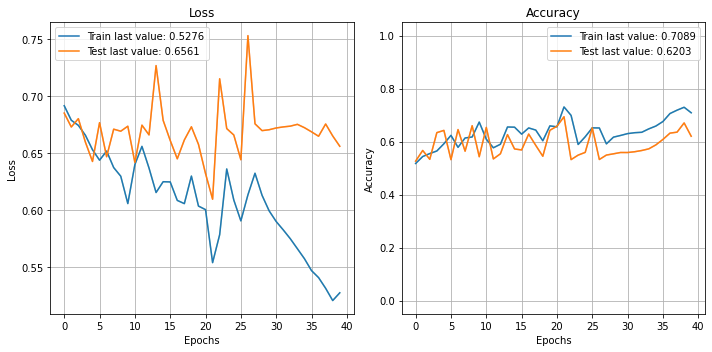

In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()

Experiment show that simply replacing the lab 2 model embeddings with pre-trained word embeddings (GloVe) will cause performance to drop significantly. 
What can you do to improve the situation?

**<i> <font color ='darkblue'> GloVe pre-trained embeddings are not customized to the data specific to the domain of our problem and hence, we can fine-tune them by making the embeddings trainable so that they can model the data from the domain under consideration better. We may also try early stopping to avoid risk of overfitting. </font></i>**

#  Model 4: Adding extra dense layer into Neural averaging network model

We add extra dense layers into model 3-1 (neural network model) to evaluate extra dense layers' contribution. We start by adding one layer, then add two. All parameters are the same as model 3-1.

### Adding one extra dense layer

In [ ]:
# Inspect model performance with 1 hidden layer, pre-trained embeddings
from keras.layers import Input, Embedding, Dense, LSTM, Lambda
from keras.models import Model
embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=True)
input_layer = Input(shape=(256,))
embedding_layer = embeddingLayer(input_layer)
pooling_layer = GlobalAveragePooling1DMasked()(embedding_layer)
extra_dense_layer = Dense(100)(pooling_layer)
dense_layer = Dense(16)(extra_dense_layer)
output_dense_layer = Dense(1, activation='sigmoid')(dense_layer)
model4 = Model(inputs= input_layer, outputs=output_dense_layer)
model4.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model4.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 256)]             0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, 256, 300)          120000300 
_________________________________________________________________
global_average_pooling1d_mas (None, 300)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_28 (Dense)             (None, 16)                1616      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 17        
Total params: 120,032,033
Trainable params: 120,032,033
Non-trainable params: 0
____________________________________________

**<i> <font color ='darkblue'> We reuse the Neural bag of words model created in section 3-1 and add another dense layer to check if that improves the model performance. </font></i>**


In [ ]:
# Model training
history = model4.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 26s 831ms/step - loss: 0.6869 - accuracy: 0.5384 - val_loss: 0.6478 - val_accuracy: 0.6393
Epoch 2/40
30/30 [==============================] - 24s 810ms/step - loss: 0.6286 - accuracy: 0.6649 - val_loss: 0.5592 - val_accuracy: 0.7460
Epoch 3/40
30/30 [==============================] - 25s 820ms/step - loss: 0.5071 - accuracy: 0.7819 - val_loss: 0.4154 - val_accuracy: 0.8226
Epoch 4/40
30/30 [==============================] - 35s 1s/step - loss: 0.3583 - accuracy: 0.8543 - val_loss: 0.3487 - val_accuracy: 0.8541
Epoch 5/40
30/30 [==============================] - 27s 866ms/step - loss: 0.2798 - accuracy: 0.8893 - val_loss: 0.3162 - val_accuracy: 0.8686
Epoch 6/40
30/30 [==============================] - 24s 816ms/step - loss: 0.2255 - accuracy: 0.9133 - val_loss: 0.3509 - val_accuracy: 0.8564
Epoch 7/40
30/30 [==============================] - 24s 809ms/step - loss: 0.2099 - accuracy: 0.9191 - val_loss: 0.3051 - val_accuracy: 0.8767
Ep

In [ ]:
# Model evaluation
results = model4.evaluate(X_test_enc, y_test)

782/782 [==============================] - 3s 4ms/step - loss: 1.2730 - accuracy: 0.8448


In [ ]:
print (results)

[1.2729591131210327, 0.8448399901390076]


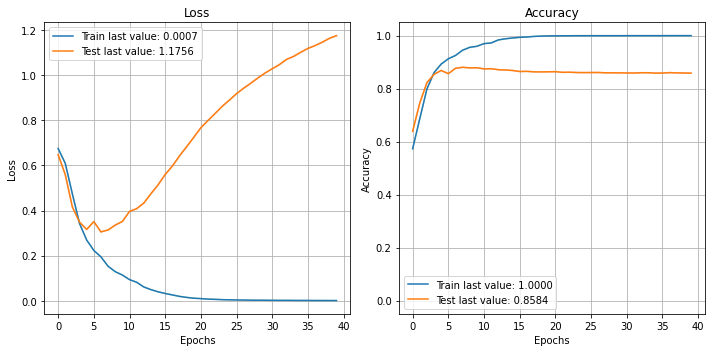

In [ ]:
# your code goes here

from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()

**<i> <font color ='darkblue'> We can observe that addition of one dense layer has improved the model performance. We now add another similar dense layer to check for performance enhancement.</font></i>**


### Adding two extra dense layers

In [ ]:
# Inspect model performance with 1 hidden layer, pre-trained embeddings
embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=True)
input_layer = Input(shape=(256,))
embedding_layer = embeddingLayer(input_layer)
pooling_layer = GlobalAveragePooling1DMasked()(embedding_layer)
extra_dense_layer_1 = Dense(300)(pooling_layer)
extra_dense_layer_2 = Dense(100)(extra_dense_layer_1)
dense_layer = Dense(16)(extra_dense_layer_2)
output_dense_layer = Dense(1, activation='sigmoid')(dense_layer)
model4 = Model(inputs= input_layer, outputs=output_dense_layer)
model4.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model4.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 256)]             0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, 256, 300)          120000300 
_________________________________________________________________
global_average_pooling1d_mas (None, 300)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_31 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_32 (Dense)             (None, 16)                1616      
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 17 

In [ ]:
# Model training
history = model4.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 26s 819ms/step - loss: 0.6855 - accuracy: 0.5495 - val_loss: 0.6283 - val_accuracy: 0.6623
Epoch 2/40
30/30 [==============================] - 24s 794ms/step - loss: 0.5824 - accuracy: 0.7066 - val_loss: 0.4426 - val_accuracy: 0.7964
Epoch 3/40
30/30 [==============================] - 24s 796ms/step - loss: 0.3902 - accuracy: 0.8296 - val_loss: 0.3759 - val_accuracy: 0.8380
Epoch 4/40
30/30 [==============================] - 24s 791ms/step - loss: 0.2821 - accuracy: 0.8843 - val_loss: 0.3522 - val_accuracy: 0.8525
Epoch 5/40
30/30 [==============================] - 24s 786ms/step - loss: 0.2342 - accuracy: 0.9063 - val_loss: 0.3169 - val_accuracy: 0.8754
Epoch 6/40
30/30 [==============================] - 24s 798ms/step - loss: 0.1739 - accuracy: 0.9361 - val_loss: 0.3436 - val_accuracy: 0.8737
Epoch 7/40
30/30 [==============================] - 24s 797ms/step - loss: 0.1342 - accuracy: 0.9530 - val_loss: 0.3776 - val_accuracy: 0.8692

In [ ]:
# Model evaluation
results = model4.evaluate(X_test_enc, y_test)

782/782 [==============================] - 3s 4ms/step - loss: 1.8261 - accuracy: 0.8420


In [ ]:
print (results)

[1.8260945081710815, 0.8419600129127502]


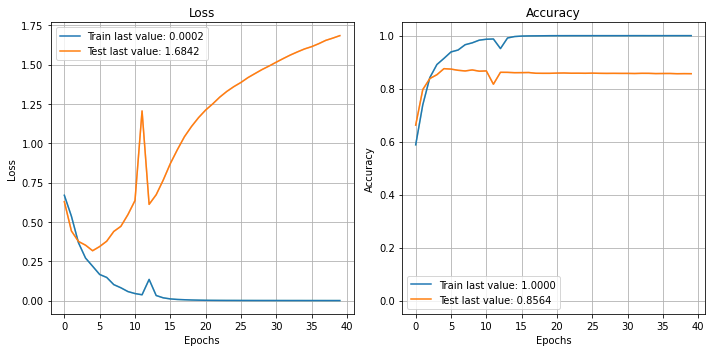

In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()

These two experiments show that adding extra dense layers can slightly improve accuracy over model 3-1.

---





**<i> <font color ='darkblue'>Adding extra layers to the model improved accuracy because a deeper network is better able to learn more complex functions than shallower networks with the same number of neurons. We notice that the training loss has decreased significantly but there is a difference in the accuracy plots between training accuracy and validation accuracy with the similar difference between the accuracy for training and test set suggesting a scope for overfitting. Measures to prevent overfitting must be considered so that the complex model does not start learning in noise and is still able to generalize well.</font></i>**

#  Model 5: CNN for Text Classification

In this section, we build a Convolutional Neural Network (CNN) for text classification. We start by using one CNN layer and then adding another layer. You could use embeddings from pre-trained or scratch.

##  Model 5-1: Basic CNN model for Text Classification 

In [ ]:
hidden_layer=16
embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)
input_layer = Input(shape=(256,))
embedding_layer = embeddingLayer(input_layer)
cnn_layer = keras.layers.Conv1D(100, 6)(embedding_layer)
pooling_layer = GlobalMaxPooling1D()(cnn_layer)
output_dense_layer = Dense(1, activation='sigmoid')(pooling_layer)
model5 = Model(inputs= input_layer, outputs=output_dense_layer)
model5.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model5.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 256)]             0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, 256, 300)          120000300 
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 251, 100)          180100    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 101       
Total params: 120,180,501
Trainable params: 180,201
Non-trainable params: 120,000,300
_________________________________________________________________


**<i> <font color ='darkblue'> In this section, we create a CNN model by adding a convolution layer while we continue to use pre-trained GloVe word embeddings. For our CNN layer, we have 100 output filters and each filter is of size 6.</font></i>**


In [ ]:
# Model training
history = model5.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 45s 1s/step - loss: 1.1214 - accuracy: 0.5088 - val_loss: 0.6664 - val_accuracy: 0.5947
Epoch 2/40
30/30 [==============================] - 44s 1s/step - loss: 0.5873 - accuracy: 0.6974 - val_loss: 0.5760 - val_accuracy: 0.7050
Epoch 3/40
30/30 [==============================] - 45s 1s/step - loss: 0.5032 - accuracy: 0.7900 - val_loss: 0.5353 - val_accuracy: 0.7378
Epoch 4/40
30/30 [==============================] - 45s 1s/step - loss: 0.4372 - accuracy: 0.8409 - val_loss: 0.5076 - val_accuracy: 0.7551
Epoch 5/40
30/30 [==============================] - 44s 1s/step - loss: 0.3942 - accuracy: 0.8723 - val_loss: 0.4867 - val_accuracy: 0.7689
Epoch 6/40
30/30 [==============================] - 45s 1s/step - loss: 0.3563 - accuracy: 0.8897 - val_loss: 0.4661 - val_accuracy: 0.7806
Epoch 7/40
30/30 [==============================] - 44s 1s/step - loss: 0.3157 - accuracy: 0.9147 - val_loss: 0.4558 - val_accuracy: 0.7865
Epoch 8/40
30/30 [==

In [ ]:
#Model evaluation
results = model5.evaluate(X_test_enc, y_test)

782/782 [==============================] - 26s 33ms/step - loss: 0.4595 - accuracy: 0.8188


In [ ]:
print (results)

[0.4595050811767578, 0.8187599778175354]


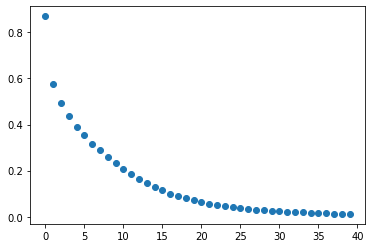

In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
#plot_history(history.history['loss'], path="standard.png")
plt.plot(history.history['loss'],'o')

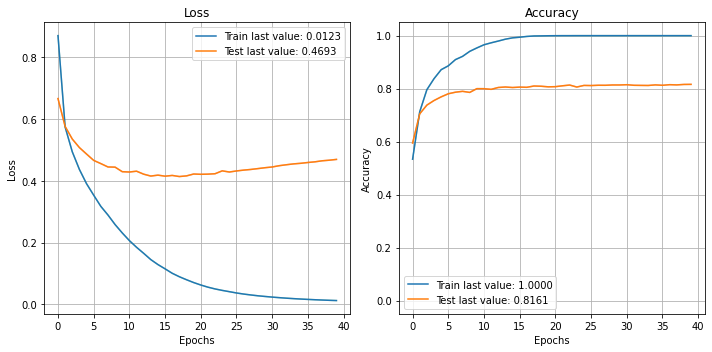

In [ ]:

from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")

## Model 5-2: Adding extra convolutional layer

In [ ]:
embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)
input_layer = Input(shape=(256,))
embedding_layer = embeddingLayer(input_layer)
cnn_layer = keras.layers.Conv1D(100, 6)(embedding_layer)
cnn_layer_2 = keras.layers.Conv1D(100, 6)(cnn_layer)
pooling_layer = GlobalMaxPooling1D()(cnn_layer_2)
output_dense_layer = Dense(1, activation='sigmoid')(pooling_layer)
model5 = Model(inputs= input_layer, outputs=output_dense_layer)
model5.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model5.summary()y

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 256)]             0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, 256, 300)          120000300 
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 251, 100)          180100    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 246, 100)          60100     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 101       
Total params: 120,240,601
Trainable params: 240,301
Non-trainable params: 120,000,300
______________________________________

**<i> <font color ='darkblue'> In the previous section, we received good results  for CNN model on test data. We now try to improve the accuracy by using an additional convolution layer keeping the configurations same. </font></i>**


In [ ]:
# Model training
history2 = model5.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)


Epoch 1/40
30/30 [==============================] - 79s 3s/step - loss: 0.8223 - accuracy: 0.5314 - val_loss: 0.6325 - val_accuracy: 0.6420
Epoch 2/40
30/30 [==============================] - 61s 2s/step - loss: 0.5526 - accuracy: 0.7492 - val_loss: 0.5604 - val_accuracy: 0.7197
Epoch 3/40
30/30 [==============================] - 61s 2s/step - loss: 0.4420 - accuracy: 0.8402 - val_loss: 0.5087 - val_accuracy: 0.7496
Epoch 4/40
30/30 [==============================] - 61s 2s/step - loss: 0.3599 - accuracy: 0.8855 - val_loss: 0.4887 - val_accuracy: 0.7597
Epoch 5/40
30/30 [==============================] - 61s 2s/step - loss: 0.3119 - accuracy: 0.8962 - val_loss: 0.4692 - val_accuracy: 0.7743
Epoch 6/40
30/30 [==============================] - 61s 2s/step - loss: 0.2602 - accuracy: 0.9333 - val_loss: 0.4513 - val_accuracy: 0.7829
Epoch 7/40
30/30 [==============================] - 61s 2s/step - loss: 0.2138 - accuracy: 0.9586 - val_loss: 0.4884 - val_accuracy: 0.7629
Epoch 8/40
30/30 [==

In [ ]:
# Model evaluation
results = model5.evaluate(X_test_enc, y_test)

782/782 [==============================] - 33s 43ms/step - loss: 0.5981 - accuracy: 0.7948


In [ ]:
print (results)

[0.5980694890022278, 0.79475998878479]


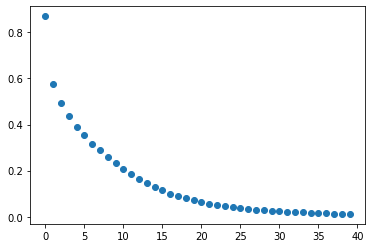

In [ ]:
# your code goes here

from plot_keras_history import plot_history
import matplotlib.pyplot as plt
#plot_history(history.history['loss'], path="standard.png")
plt.plot(history.history['loss'],'o')

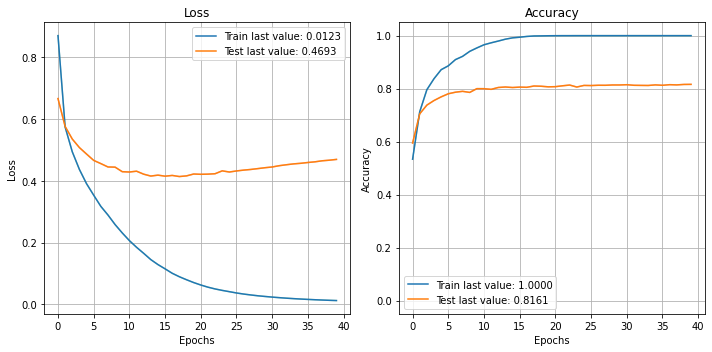

In [ ]:

from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")

**<i> <font color ='darkblue'> It is easily noticeable that the CNN with additional layers gives lower accuracy on the test set when compared to models from the previous section. Studying the graphs, we see that CNN with additional layers is also more prone to overfitting as compared to denser neural averaging network model. Making CNN deeper increases the number of weights and hence the complexity which is leading it to overfit in this case resulting in a lower accuracy on test set.</font></i>**


Although adding layer here reduces the training loss, the evaluation accuracy is worse than the model without the extra convolutional layer.

Adding more layers can help you to extract more features. But we can do that up to a certain extent. After some point, instead of extracting features, we tend to overfit the data. Overfitting can lead to errors in on form or another, such as false positives. It is not easy to choose the number of units in a hidden layer or the number of hidden layers in a neural network. For many applications, one hidden layer is enough. As a general rule, the number of units in that hidden layer is between the number of inputs and the number of outputs.
 The best way to decide on the number of units and hidden layers is to try various parameters. Train several neural networks with different numbers of hidden layers and neurons, and monitor the performance of them. You will have to experiment using a series of different architectures. 







---

